In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kirklist_converted.xlsx to kirklist_converted (1).xlsx


In [ ]:
import pandas as pd

xls = pd.ExcelFile("kirklist_converted.xlsx")

sheet_names = xls.sheet_names
print(sheet_names)  # Explore all sheet names

# Load the relevant sheets
itemlist = pd.read_excel(xls, sheet_name="ITEMLIST")
list_tab = pd.read_excel(xls, sheet_name="List", header=1)  # Skip header row

itemlist.columns = itemlist.columns.str.strip()
list_tab.columns = list_tab.columns.str.strip()

itemlist['아이템번호'] = itemlist['아이템번호'].astype(str).str.strip().str.upper()
list_tab['Item'] = list_tab['Item'].astype(str).str.strip().str.upper()
itemlist['아이템명'] = itemlist['아이템명'].astype(str).str.strip().str.upper()
list_tab['Date'] = list_tab['Date'].astype(str).str.strip().str.upper()

# Merge on both item code and item name/date
merged = pd.merge(itemlist, list_tab, left_on=["아이템번호", "아이템명"], right_on=["Item", "Date"], how="inner")

# Preview the result
merged.head()

['ITEMLIST', 'List', 'CNA-1', 'SANGWOO(ZARA)', 'CNA', 'mango', 'Alfani', "Macy's (2)", 'Style&Co', 'INC', "New Form_Macy's", '출력양식 (2)', '스티커(3)', '스티커(4)', '스티커(JY)', 'BRFS', 'GO', 'GO (2)', 'GO(NEW)', 'BRFS(NEW)', 'BRFS(PC)', 'FDS', 'FDS (JY)', 'ONY', 'Sheet1', 'FDS (2)', 'BRFS(NEW) (2)']


,아이템번호,아이템명,조직,가격,Price_Date,Hs No,Season_x,"43/44""",Cut,Gm/㎡,...,25 DAYS,30 DAYS AFTER ORDER CFM,"100,000Y",NaN,NaN,"1,000YD",500YD,Weight.1,Weight-1.1,CW.1
0,JBS-865279,TG-865279,NaN,2.14,2020-05-19 00:00:00,NaN,NaN,"56/57""",55.0,250.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250,7.37,55
1,JBS-865281,TG-865281,NaN,2.14,2020-05-19 00:00:00,NaN,NaN,"56/57""",55.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270,7.96,55
2,JBS-865308,TG-865308,NaN,2.3,2020-05-28 00:00:00,NaN,NaN,"57/58""",56.0,205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205,6.05,56
3,JBS-865309,TG-865309,NaN,3.1,2020-05-28 00:00:00,NaN,NaN,"57/58""",56.0,208.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208,6.14,56
4,JBS-865311,TG-865311,NaN,3.2,2020-05-28 00:00:00,NaN,NaN,"57/58""",56.0,250.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250,7.37,56


In [ ]:
import re

# Function to parse material percentages from strings like "65% CO 35% PE"
def parse_materials(s):
    if pd.isnull(s):
        return {}
    matches = re.findall(r'(\d+\.?\d*)%\s*([A-Z]+)', s.upper())
    return {mat: float(pct)/100 for pct, mat in matches}

# Apply to the merged Content column
material_data = merged['Content'].apply(parse_materials)

# Convert list of dicts to dataframe
materials_df = pd.DataFrame(material_data.tolist()).fillna(0)

# Combine with original margin
material_margin_df = pd.concat([materials_df, merged["Margin"]], axis=1)

material_margin_df.head()

,CO,SPAN,PE,PA,VI,SP,TENCEL,LI,WO,OTHERS,...,TEN,PVC,NYLON,COTTON,MT,BCI,SORONA,SPA,HSY,Margin
0,0.97,0.03,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.70,0.02,0.28,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.45
2,0.46,0.02,0.52,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.98,0.02,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.46,0.03,0.00,0.51,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [ ]:
# Clean and convert margin column
material_margin_df["Margin"] = material_margin_df["Margin"].astype(str).str.replace("$", "", regex=False)
material_margin_df["Margin"] = pd.to_numeric(material_margin_df["Margin"], errors="coerce")

# Confirm no more strings or NaNs
print(material_margin_df["Margin"].dtype)
print("Missing:", material_margin_df["Margin"].isna().sum())

# Drop Margin to isolate material composition
materials_only = material_margin_df.drop(columns="Margin")

# Convert all remaining columns to numeric again just to be safe
materials_only = materials_only.apply(pd.to_numeric, errors="coerce")

# Weighted margin = % of material * total margin
material_margin_sum = materials_only.multiply(material_margin_df["Margin"], axis=0)

# Sum to get total margin contribution by material
total_margin_by_material = material_margin_sum.sum().sort_values(ascending=False)

# Display result
total_margin_by_material.head(10)

float64
Missing: 995


,0
PE,418.032525
CO,240.626740
VI,110.511800
PA,51.471455
AC,17.099500
SPAN,14.352880
LI,14.210500
TENCEL,10.870000
WO,3.900500
OTHERS,3.087500


In [ ]:
# Combine CO and COTTON into COTTON
if 'CO' in materials_only.columns and 'COTTON' in materials_only.columns:
    materials_only["COTTON"] += materials_only["CO"]
    materials_only.drop(columns=["CO"], inplace=True)
elif 'CO' in materials_only.columns:
    materials_only.rename(columns={"CO": "COTTON"}, inplace=True)

# Combine WO and OTEHRS into WOOL
for col in ["WO", "OTEHRS"]:
    if col in materials_only.columns:
        if "WOOL" not in materials_only.columns:
            materials_only["WOOL"] = 0
        materials_only["WOOL"] += materials_only[col]
        materials_only.drop(columns=[col], inplace=True)


# Repeat same merge for full dataset if you're still using material_margin_df
for col in ["CO", "COTTON"]:
    if col in material_margin_df.columns:
        material_margin_df["COTTON"] = material_margin_df.get("COTTON", 0) + material_margin_df[col]
        if col != "COTTON":
            material_margin_df.drop(columns=[col], inplace=True)

for col in ["WO", "OTEHRS"]:
    if col in material_margin_df.columns:
        material_margin_df["WOOL"] = material_margin_df.get("WOOL", 0) + material_margin_df[col]
        if col != "WOOL":
            material_margin_df.drop(columns=[col], inplace=True)

In [ ]:
# Multiply and sum again
material_margin_sum = materials_only.multiply(material_margin_df["Margin"], axis=0)
total_margin_by_material = material_margin_sum.sum().sort_values(ascending=False)

# Display
total_margin_by_material.head(10)

,0
PE,418.032525
COTTON,241.526740
VI,110.511800
PA,51.471455
AC,17.099500
SPAN,14.352880
LI,14.210500
TENCEL,10.870000
WOOL,5.905500
OTHERS,3.087500


In [ ]:
# Merge already has all fields, so group by Content
top_by_material = filtered.groupby("Content")["Margin"].mean().sort_values(ascending=False)
top_by_material.head(10)

,Margin
Content,
68% CO 29% PA 3% SPAN,2.330000
60% CO 38% PA 2% SPAN,1.440000
75% PA 17% PE 8% SPAN,1.000000
100% PE (RECYCLED),0.850000
64% VI 36% PE,0.800000
100% PE (T-800),0.750000
94% PA 6% SPAN,0.660000
50% WOOL 50% OTEHRS,0.650000
99% CO 1% LUREX,0.640000


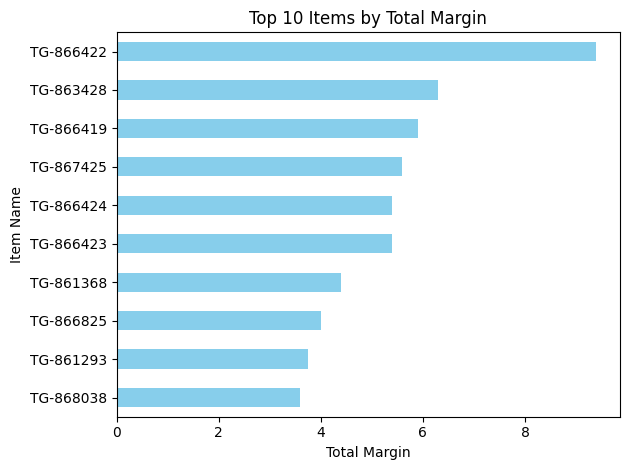

In [ ]:
import matplotlib.pyplot as plt

# Plot top 10 products
top_products.head(10).plot(kind="barh", color="skyblue")
plt.gca().invert_yaxis()
plt.title("Top 10 Items by Total Margin")
plt.xlabel("Total Margin")
plt.ylabel("Item Name")
plt.tight_layout()
plt.show()

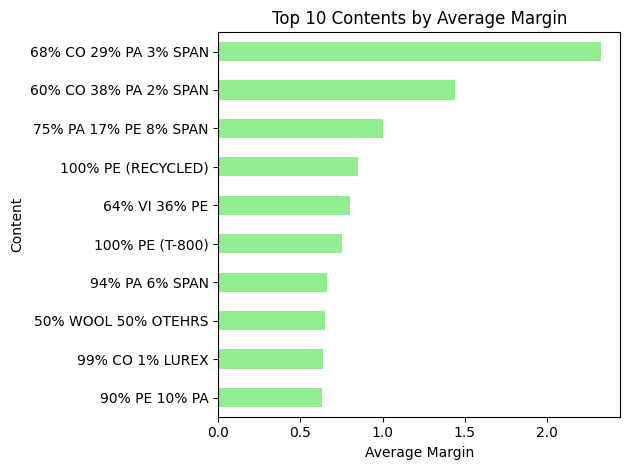

In [ ]:
top_by_material = filtered.groupby("Content")["Margin"].mean().sort_values(ascending=False)

top_by_material.head(10).plot(kind="barh", color="lightgreen")
plt.gca().invert_yaxis()
plt.title("Top 10 Contents by Average Margin")
plt.xlabel("Average Margin")
plt.ylabel("Content")
plt.tight_layout()
plt.show()

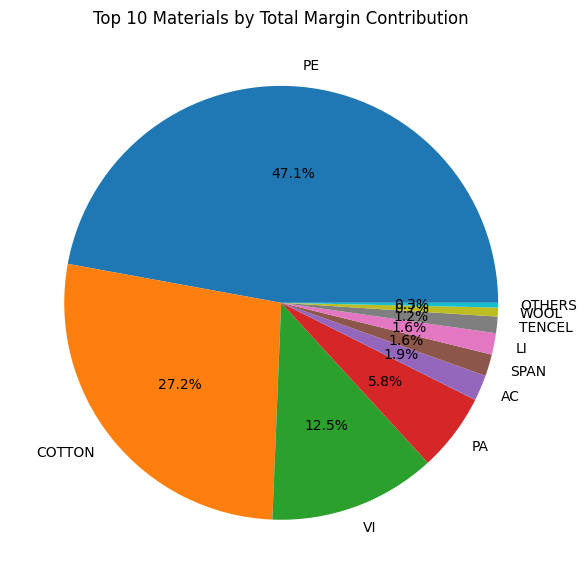

In [ ]:
# Use already cleaned + combined material data
total_margin_by_material.head(10).plot(kind="pie", autopct="%1.1f%%", figsize=(6, 6))
plt.title("Top 10 Materials by Total Margin Contribution")
plt.ylabel("")  # Hide y-label
plt.tight_layout()
plt.show()

In [ ]:
filtered.to_csv("cleaned_for_powerbi.csv", index=False)
from google.colab import files
files.download("cleaned_for_powerbi.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
total_margin_by_material.to_csv("material_margin_summary.csv")
files.download("material_margin_summary.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()